In [15]:
import os
import json
import cv2
import numpy as np
from pycocotools.mask import decode
import matplotlib.pyplot as plt
from PIL import Image


path = '/scratch/dr/m.badran/pengwin/Exps/output/mask_rcnn/50/preds/081_0000.json'

# Load the JSON file
with open(path, 'r') as f:
    data = json.load(f)
print(data.keys())
# Iterate through the results
# image_id = data['image_id']
bbox = data['bboxes']
score = data['scores']
category_id = data['labels']
mask_rle = data['masks']  # This is in RLE format

# Decode the RLE to a binary mask
mask = decode(mask_rle)
print(mask)

# Load the corresponding image (assuming the image filename is the same as image_id)
image_path = f'/scratch/dr/y.nawar/pengwin/train/input/images/x-ray/081_0000.tif'
image = np.array(Image.open(image_path))
print(image.shape)
# Resize the mask to the same size as the image
# mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))

# Convert the mask to binary (0 or 255)
# mask_binary = (mask_resized * 255).astype(np.uint8)

# Visualize the mask on the image

# Show the image with the mask
# plt.imshow(mask_binary)
# plt.show()

# # Optionally, save the masked image
# output_path = f'path_to_save_masked_images/{image_id}_masked.jpg'
# cv2.imwrite(output_path, masked_image)


dict_keys(['labels', 'scores', 'bboxes', 'masks'])
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
(448, 448)


In [4]:
import json
import numpy as np
from pycocotools import mask as maskUtils
import json
import os
from pycocotools.mask import decode
from PIL import Image
# from pengwin_utils import masks_to_seg
# CATEGORIES: dict[str, int] = {
#     "SA": 1,
#     "LI": 2,
#     "RI": 3,
# }

# def seg_to_masks(seg):
#     """Convert a binary-encoded multi-label segmentation to masks."""
#     category_ids = []
#     fragment_ids = []
#     masks = []
#     for category_id in CATEGORIES.values():
#         for fragment_id in range(1, 11):
#             mask = np.right_shift(seg, _shift(category_id, fragment_id)) & 1
#             if mask.sum() > 0:
#                 masks.append(mask)
#                 category_ids.append(category_id)
#                 fragment_ids.append(fragment_id)
#     return np.array(masks), category_ids, fragment_ids

def _shift(category_id, fragment_id):
    return 10 * (category_id - 1) + fragment_id

def masks_to_seg(masks, category_ids, fragment_ids):
    seg = np.zeros((masks.shape[1], masks.shape[2]), dtype=np.uint32)
    masks = masks.astype(np.uint32)
    for mask, category_id, fragment_id in zip(masks, category_ids, fragment_ids):
        seg = np.bitwise_or(seg, np.left_shift(mask, _shift(category_id, fragment_id)))
    return seg

def json_to_tif(json_path, output_path, threshold=0.5):
    f_path = os.path.join(json_path)
    print(f_path)
    with open(f_path, 'r') as file:
        data = json.load(file)

    # Filter the predictions based on the scores
    filtered_indices = [i for i, score in enumerate(data['scores']) if score >= threshold]

    data = {
        "labels": [data['labels'][i] for i in filtered_indices],
        "scores": [data['scores'][i] for i in filtered_indices],
        "bboxes": [data['bboxes'][i] for i in filtered_indices],
        "masks": [data['masks'][i] for i in filtered_indices]
    }
    mask_rle = data['masks']
    mask = decode(mask_rle)
    frag_ids = []
    sa = 1
    li = 1
    ri = 1
    for i in data['labels']:
        if i == 1:
            frag_ids.append(sa)
            sa += 1
        elif i== 2:
            frag_ids.append(li)
            li += 1
        else:
            frag_ids.append(ri)
            ri += 1
    mask = mask.transpose(2,0,1).astype('uint8')
    cats = []
    for cat in data['labels']:
        cats.append(cat + 1)

    seg = masks_to_seg(mask, cats, frag_ids)
    # print(np.unique(seg))
    # masks , _ , _ = seg_to_masks(seg)
    # print(np.unique(masks[2]))
    Image.fromarray(seg).save(output_path)
    return seg

seg = json_to_tif('/scratch/dr/m.badran/pengwin/Exps/output/mask_rcnn/50/preds/081_0025.json', '081_0025.tif')

/scratch/dr/m.badran/pengwin/Exps/output/mask_rcnn/50/preds/081_0025.json


[1, 2, 3, 3]


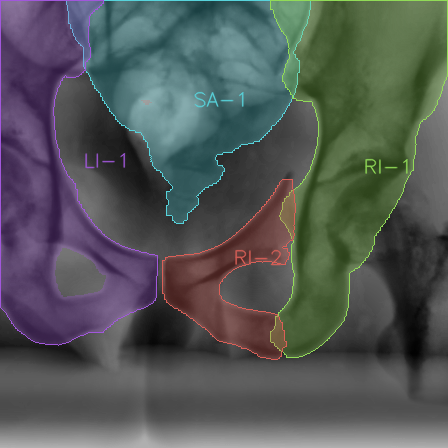

[1, 2, 2, 3, 3, 3]


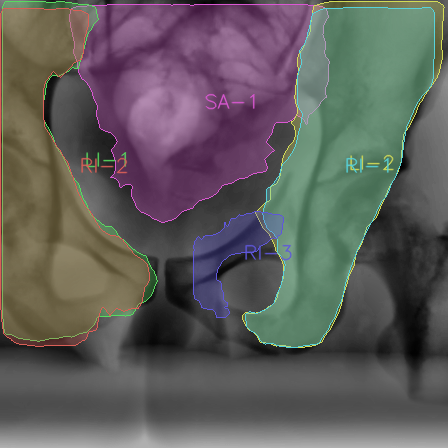

In [6]:
import peng_utils
from PIL import Image

image_path = "/scratch/dr/y.nawar/pengwin/train/input/images/x-ray/081_0025.tif"
seg_path = "/scratch/dr/y.nawar/pengwin/train/output/images/x-ray/081_0025.tif"
pred_mask = '081_0025.tif'
# load image and masks
image = peng_utils.load_image(image_path) # raw intensity image
masks, category_ids, fragment_ids = peng_utils.load_masks(seg_path)
print(category_ids)
# save visualization of image and masks
# applies CLAHE normalization to the raw intensity image before overlaying segmentations.
vis_image = peng_utils.visualize_sample(image, masks, category_ids, fragment_ids)
Image.fromarray(vis_image).show()

# Obtain predicted masks, category_ids, and fragment_ids
# Category IDs are {"SA": 1, "LI": 2, "RI": 3}
# Fragment IDs are the integer labels from label_{category}.nii.gz, with 1 corresponding to the main fragment.
masks, category_ids, fragment_ids = peng_utils.load_masks(pred_mask)
pred_masks, pred_category_ids, pred_fragment_ids = masks, category_ids, fragment_ids 
print(pred_category_ids)
vis_image = peng_utils.visualize_sample(image, masks, category_ids, fragment_ids)
Image.fromarray(vis_image).show()



In [1]:
from pengwin_eval import evaluate_2d_single_case , load_mask_from_folder , load_masks ,Path
pred_mask = load_mask_from_folder(location=Path("/scratch/dr/m.badran/pengwin/Nawar/mmdetection/"))
gt_mask = load_masks(Path("/scratch/dr/y.nawar/pengwin/train/output/images/x-ray/081_0025.tif"))
metrics_single_case = evaluate_2d_single_case(gt_mask, pred_mask, verbose=False)
print(metrics_single_case)

{'fracture_iou': 0.6576891497049109, 'fracture_hd95': 41.328255748748774, 'fracture_assd': 11.830668807029724, 'anatomical_iou': 0.5276835593854597, 'anatomical_hd95': 194.09783337910963, 'anatomical_assd': 36.18518320719401}
